# Chapter 4: Transfer Learning And Other Tricks

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
transfer_model = models.resnet50(pretrained=True) 

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/9204057K/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


## Freezing parameters

In [5]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

## Replacing the classifier

In [6]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2)) 

## Training Again

In [7]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [9]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "../train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "../val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

In [11]:
print(len(val_data_loader.dataset))

107


In [12]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [13]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=5,
      device=device)

/var/folders/x5/48zrqp5j59s3dl40qn9shksr0000gp/T/ipykernel_7284/1650489001.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 0.53, Validation Loss: 0.97, accuracy = 0.64
Epoch: 2, Training Loss: 0.19, Validation Loss: 0.44, accuracy = 0.79
Epoch: 3, Training Loss: 0.06, Validation Loss: 0.27, accuracy = 0.89
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.28, accuracy = 0.91
Epoch: 5, Training Loss: 0.06, Validation Loss: 0.80, accuracy = 0.79


## LR Finder

In [14]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses


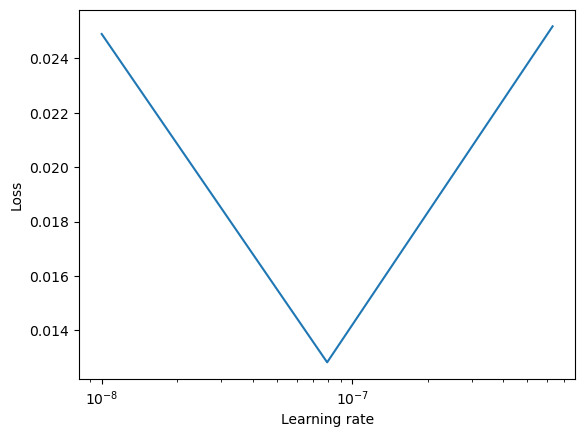

In [15]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

## Custom Transforms

Here we'll create a lambda transform and a custom transform class.

In [16]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output 

In [17]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [18]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [19]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [20]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

## Ensembles

Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

In [21]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

/var/folders/x5/48zrqp5j59s3dl40qn9shksr0000gp/T/ipykernel_7284/210517164.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble]


In [22]:
avg_prediction

tensor(917, device='mps:0')

In [23]:
torch.stack(predictions)

tensor([[[0.0009, 0.0005, 0.0007,  ..., 0.0002, 0.0005, 0.0007]],

        [[0.0009, 0.0016, 0.0020,  ..., 0.0009, 0.0006, 0.0031]]],
       device='mps:0', grad_fn=<StackBackward0>)